# Object Detection

Classification can tell you what object you are seeing, but you may also need to answer:
* Where is an object?
* How many are there?

We generally call this object detection

# Outline



* Our Goal for this lecture is to identify signs of Malaria in human blood smears




## Challenge Data Set

*P. vivax* (malaria) infected human blood smears

Accession number BBBC041 · Version 1



From the Broad Institute https://data.broadinstitute.org/bbbc/BBBC041/


<img src=https://data.broadinstitute.org/bbbc/BBBC041/BBBC041_example1.png>
    
Malaria is a disease caused by *Plasmodium* parasites that remains a major threat in global health, affecting 200 million people and causing 400,000 deaths a year. The main species of malaria that affect humans are *Plasmodium falciparum* and *Plasmodium vivax*.

For malaria as well as other microbial infections, manual inspection of thick and thin blood smears by trained microscopists remains the gold standard for parasite detection and stage determination because of its low reagent and instrument cost and high flexibility. Despite manual inspection being extremely low throughput and susceptible to human bias, automatic counting software remains largely unused because of the wide range of variations in brightfield microscopy images. However, a robust automatic counting and cell classification solution would provide enormous benefits due to faster and more accurate quantitative results without human variability; researchers and medical professionals could better characterize stage-specific drug targets and better quantify patient reactions to drugs.

Previous attempts to automate the process of identifying and quantifying malaria have not gained major traction partly due to difficulty of replication, comparison, and extension. Authors also rarely make their image sets available, which precludes replication of results and assessment of potential improvements. The lack of a standard set of images nor standard set of metrics used to report results has impeded the field. 



# Coordinates 

We are going to use the index coordinate system

<img src=../assets/index_coords.png>

* **Packages often have different systems so be careful!**
    

## Bounding Boxes

Data is often labeled by bounding boxes, which also can be describe in a number of different ways. We'll use 
Upper left corner (note this is the smallest y-coordinate), the length and the width. 

<img src=../assets/BBox.png>

Each bounding box also has a category attached to it. For example moon or cloud.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from bbtoydata import BBToyData
import matplotlib.patches as patches
import tensorflow as tf



In [ ]:
#Lets Practice

In [ ]:
x_pixel=0
y_pixel=1



img=np.zeros((3,3))

img[y_pixel,x_pixel]=1.0## Notice y,x here 

fig,ax = plt.subplots(1)

ax.imshow(img,cmap='gray')

plt.xlabel(r" X -0.5 $\rightarrow$ 3.5 ")
plt.ylabel(r" 2.5 $\leftarrow$ -0.5  Y ")
print(img)


##Draw a bounding box
rec_corner=((x_pixel-0.5,y_pixel-0.5)) #half a pixel Width
width=1
height=1
# We'll uses pat
rec=patches.Rectangle(rec_corner, width,height,edgecolor='r',facecolor='none')
ax.add_patch(rec)
plt.show()

We'll add a lot of bounding boxes so let's write a function to do it

## Quick Test
Draw a 2x2 box in the lower left hand corner of the image

In [ ]:
# We'll be drawing a lot of boxes so lets  make it a function

In [ ]:
def add_bbox(ax,bbox,color='r'):
    corner_x,corner_y,width,height=bbox
    rec=patches.Rectangle((corner_x-0.5,corner_y-0.5), width,height,edgecolor=color,facecolor='none')
    ax.add_patch(rec)

    

## Identifying where something is with a neural network

Again, we'll use a toy example that's easy to under and visualize.

Start by finding just one object.

* 3-Object Classes 
    * Square
    * Circle
    * Triangle
* 1 - Background Class

* 4 - bbox x, y, width, height

We need a classification network to identify the shape, and a new network go predict the bounding box

* We'll use two prediction networks that share features!

<img src=../assets/network_diagrams/1_object_identifier.png>



# Toy Data

We'll use a set of images that contain either a square, circle, triangle, or nothing.

* Goal will be to identify the object, and draw a bounding box around it




In [ ]:
bb=BBToyData()

[]


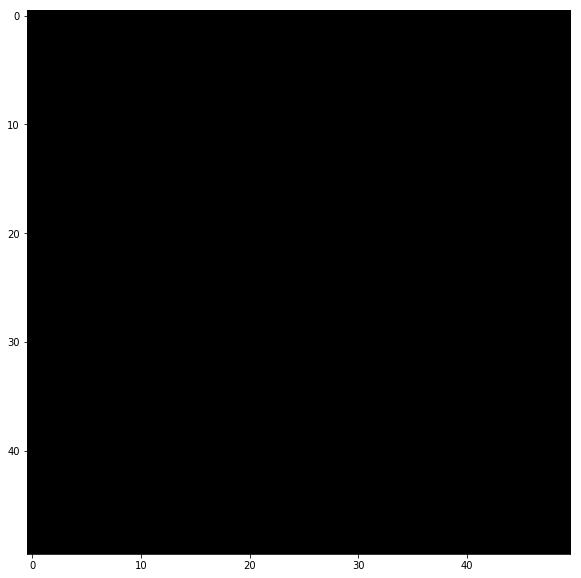

[[0, [20.51497476555046, 7.221563499870172, 22.247246023863603, 18.48921949526567]]]


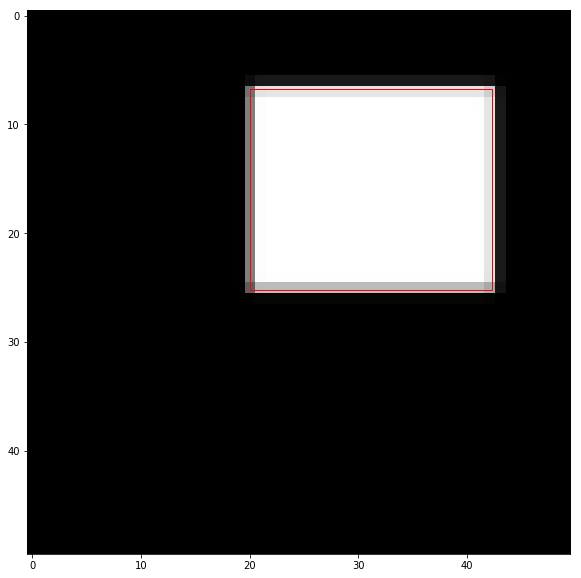

[[2, [18.58934573263341, 11.27846719263515, 22.51770293204178, 20.75665912833497]]]


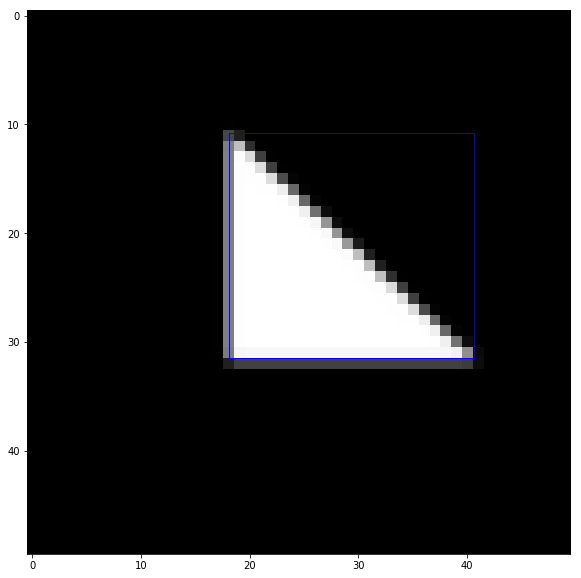

[[0, [15.828361358430593, 22.038620725397635, 23.922792249369184, 8.289317454098082]]]


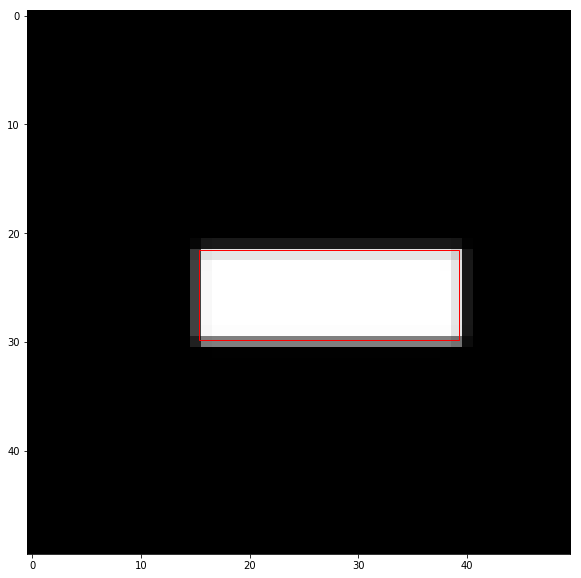

[[0, [13.0655310959709, 8.927680175564747, 27.404815811435522, 27.681003408731286]]]


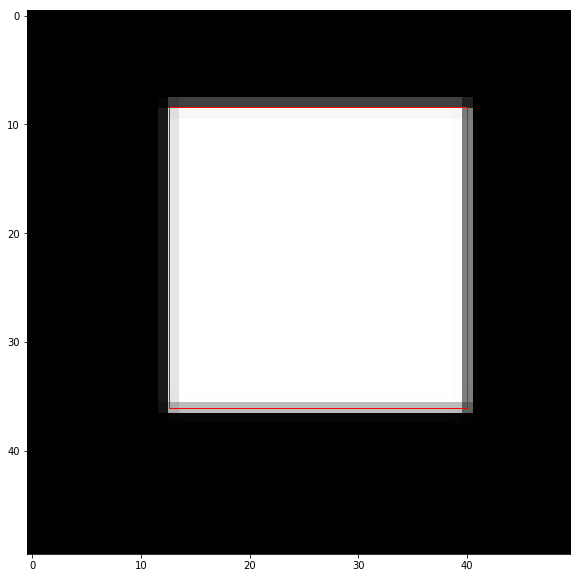

[]


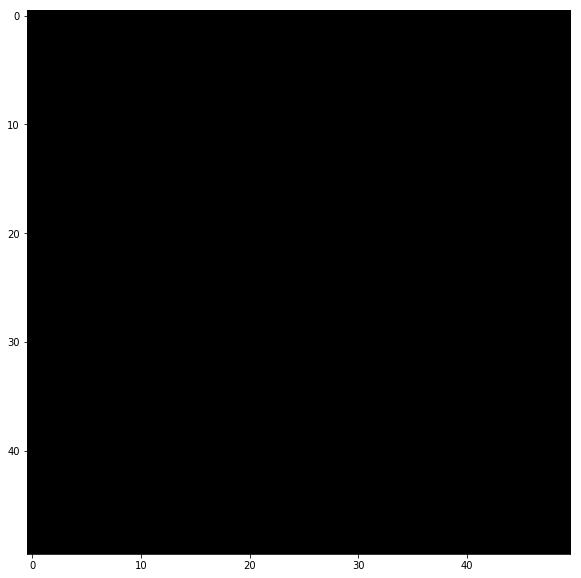

[]


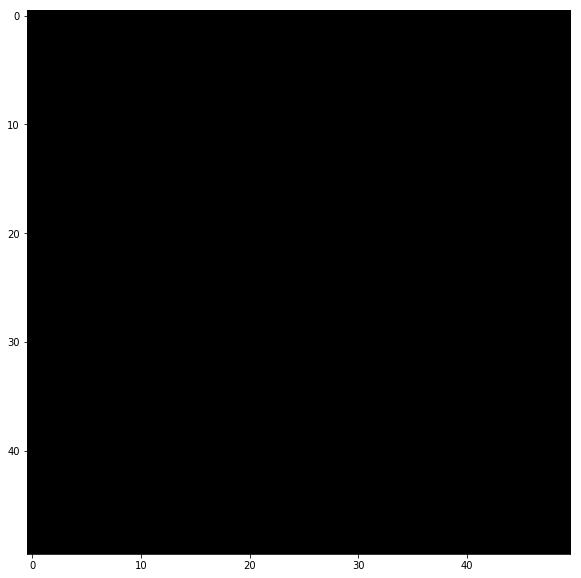

[]


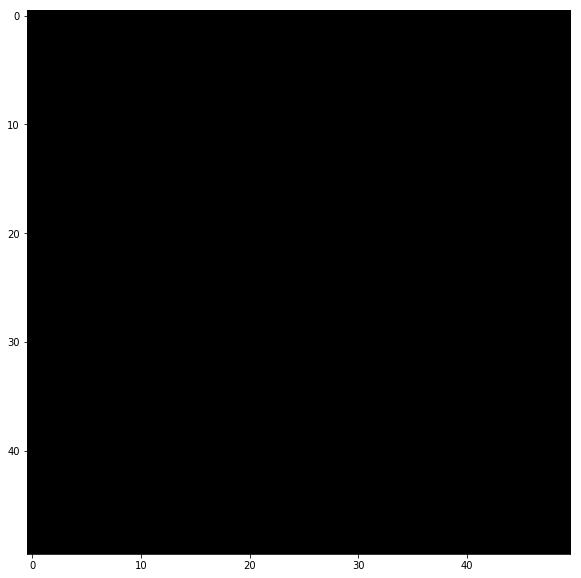

[[0, [19.885172681214115, 15.211363553115726, 20.76074107959452, 18.235669229167456]]]


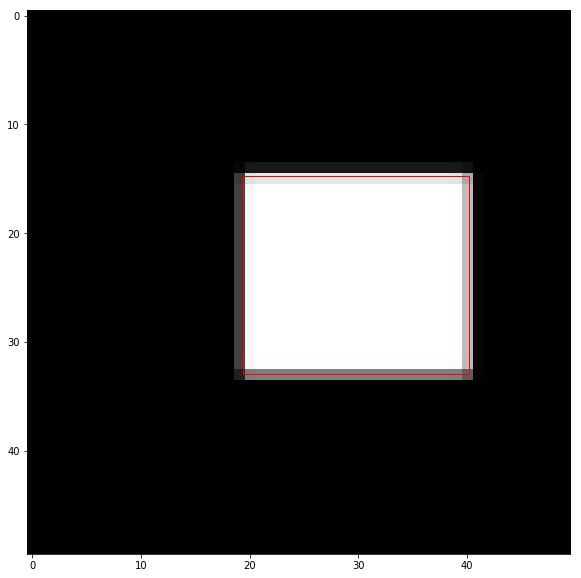

[[2, [22.77056320447673, 12.245573755664832, 21.556846406692763, 20.15819945452801]]]


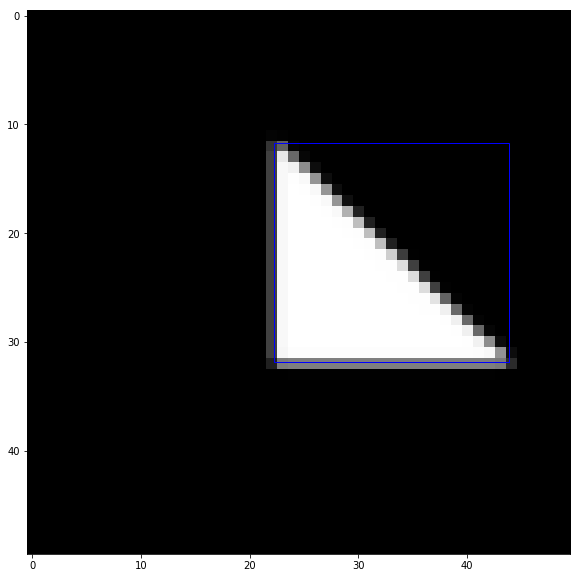

In [ ]:
def plot_example(image,labels):
    colors=['r','g','b','y','#000000']
    fig,ax = plt.subplots(1,figsize=(10,10))
    ax.imshow(image,cmap='gray')
    for cat,bbox in labels:
        add_bbox(ax,bbox,color=colors[cat])
    plt.show()
    
    
for i in range(10):
    index=np.random.randint(bb.X_train.shape[0])
    print(bb.Y_train[index])

    plot_example(np.squeeze(bb.X_train[index]),(bb.Y_train[index]))



## Build our Convolutional Feature Finders

In [ ]:
cnn_input=tf.keras.layers.Input( shape=bb.X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 

cnn_layer2=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 

#cnn_layer3=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
#cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 

flat=tf.keras.layers.Flatten()(cnn_activation) 
flat=tf.keras.layers.Dropout(0.5)(flat)



In [ ]:
#Make Our Prediction layer
cat_output_layer=tf.keras.layers.Dense(4)(flat) 
cat_output=tf.keras.layers.Activation('softmax')(cat_output_layer)


#Make our bounding box regressor
bbox_output=tf.keras.layers.Dense(50)(flat) 
bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)
bbox_output=tf.keras.layers.Dense(50)(bbox_output) 
bbox_output=tf.keras.layers.LeakyReLU()(bbox_output)
bbox_output=tf.keras.layers.Dense(4)(bbox_output) 







In [ ]:
model=tf.keras.models.Model(cnn_input,[cat_output,bbox_output])


##Two!! loss fuctions one for each output, the total loss is the sum of each of these
model.compile(loss=['categorical_crossentropy','mae'],
              optimizer='adam',
              metrics=[])
model.summary()


# Make our Data
We need to transform labels from a list to a one hot encoding


In [ ]:

def get_single_object_labels(labels):
    Y_bbox=[]
    Y_cat=[]
    for l in labels:
        if len(l)==0:
            Y_cat.append(3) #Background
            Y_bbox.append(np.array([[0,0,1,1]])) #Divide by our image size so everything is between 0-1
        else:
            cat,bbox=l[0]
            Y_cat.append(cat)
            Y_bbox.append(np.expand_dims(bbox,0)/50,) #Divide by our image size so everything is between 0-1
    Y_cat=tf.keras.utils.to_categorical(Y_cat, num_classes=4)
    Y_bbox=np.concatenate(Y_bbox)
    return [Y_cat,Y_bbox]

Y_train=get_single_object_labels(bb.Y_train)
Y_develop=get_single_object_labels(bb.Y_develop)
Y_test=get_single_object_labels(bb.Y_test)


In [12]:

history=model.fit(bb.X_train, Y_train, 
          batch_size=32, epochs=25, verbose=1,
         validation_data=(bb.X_develop,Y_develop)
         )

Train on 15987 samples, validate on 2006 samples
Epoch 1/25
15987/15987 [==============================] - 53s 3ms/step - loss: 0.4728 - activation_loss: 0.3992 - dense_3_loss: 0.0736 - val_loss: 0.2077 - val_activation_loss: 0.1671 - val_dense_3_loss: 0.0406
Epoch 2/25
15987/15987 [==============================] - 39s 2ms/step - loss: 0.1600 - activation_loss: 0.1177 - dense_3_loss: 0.0424 - val_loss: 0.1052 - val_activation_loss: 0.0769 - val_dense_3_loss: 0.0283
Epoch 3/25
15987/15987 [==============================] - 46s 3ms/step - loss: 0.1070 - activation_loss: 0.0714 - dense_3_loss: 0.0355 - val_loss: 0.1095 - val_activation_loss: 0.0787 - val_dense_3_loss: 0.0308
Epoch 4/25
15987/15987 [==============================] - 38s 2ms/step - loss: 0.0904 - activation_loss: 0.0565 - dense_3_loss: 0.0339 - val_loss: 0.0797 - val_activation_loss: 0.0499 - val_dense_3_loss: 0.0298
Epoch 5/25
15987/15987 [==============================] - 33s 2ms/step - loss: 0.0777 - activation_loss: 0.

In [13]:
cat_pred,bbox_pred=model.predict(bb.X_develop)

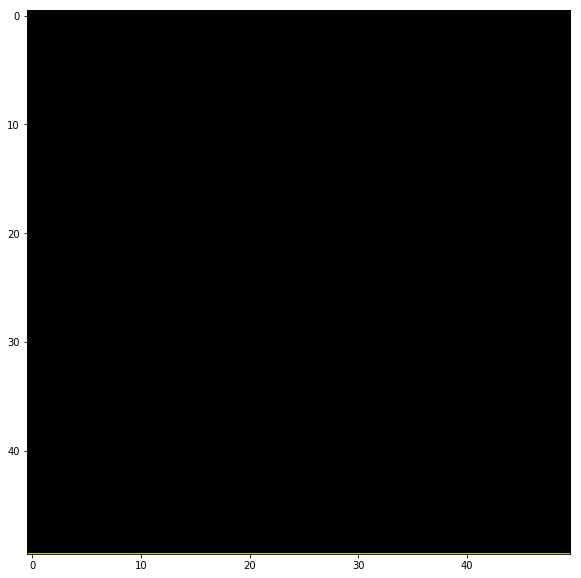

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


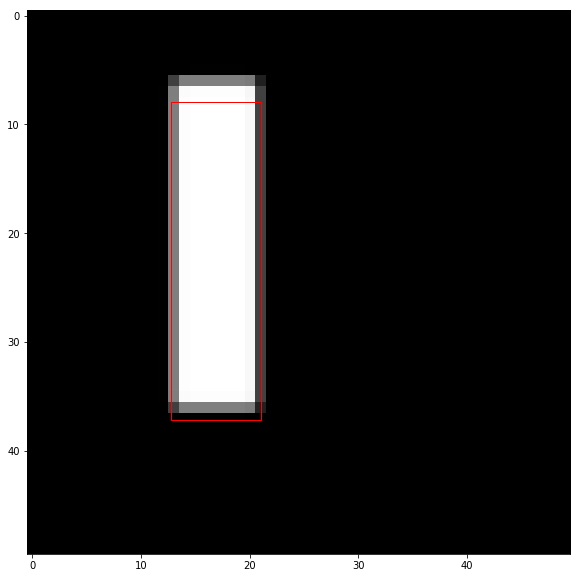

0 [26.575964 16.926718 16.433863 58.432484]
[[0, [13.58385768006572, 6.67533795612704, 7.426542527104784, 29.624144211178383]]]


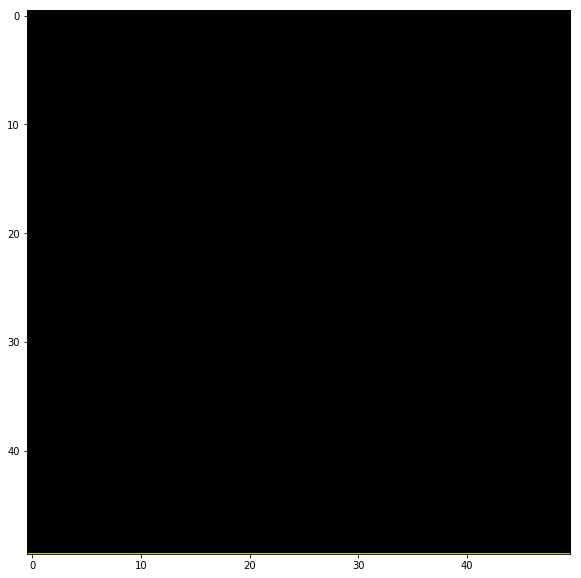

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


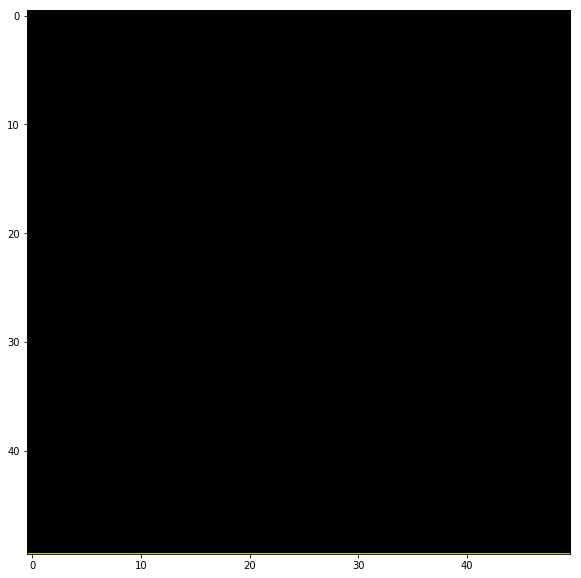

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


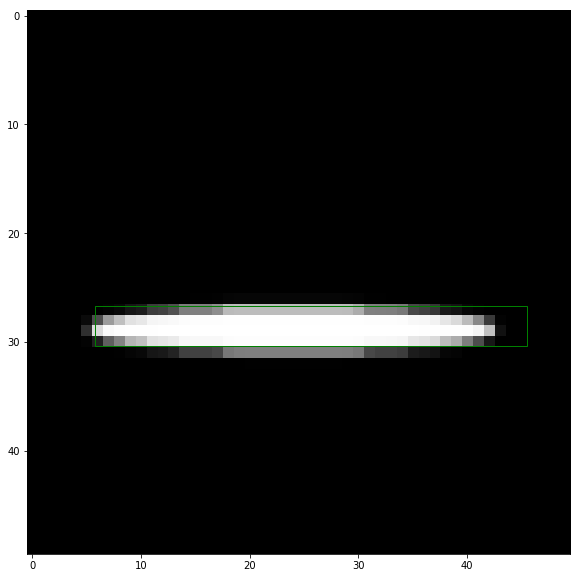

1 [12.592536  54.402565  79.4789     7.3854403]
[[1, [5.903971452454044, 27.2800573352363, 36.92258540789452, 4.036771310325088]]]


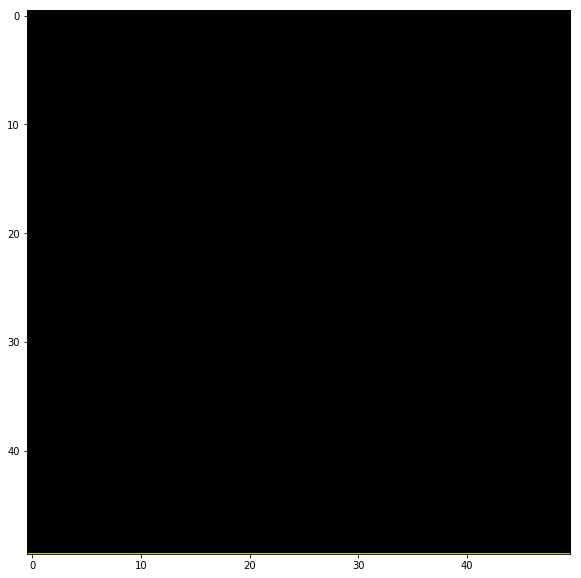

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


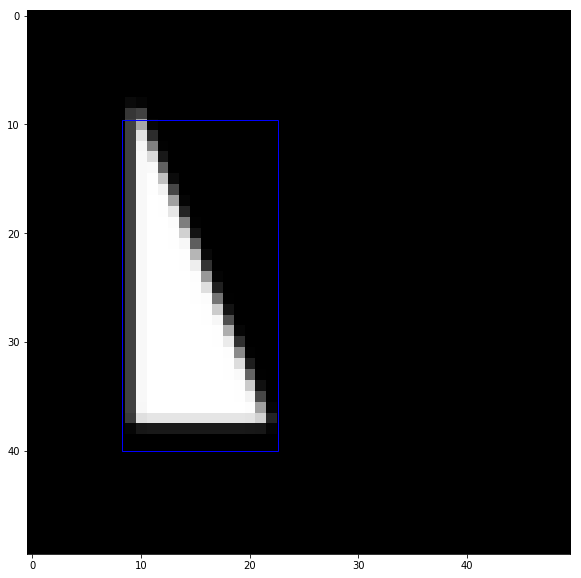

2 [17.55972  20.275291 28.695335 60.877766]
[[2, [9.875446284820809, 8.806931877702882, 12.233953414909783, 29.05325582167208]]]


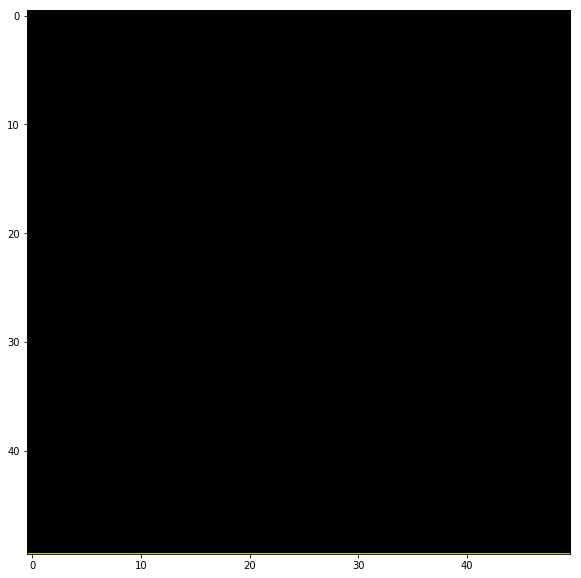

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


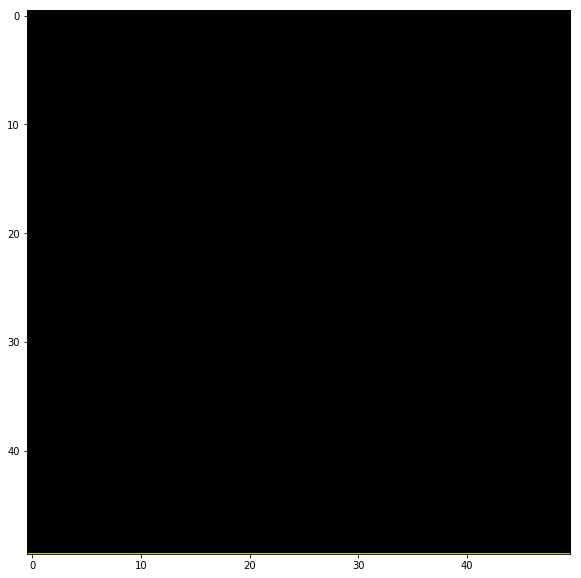

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


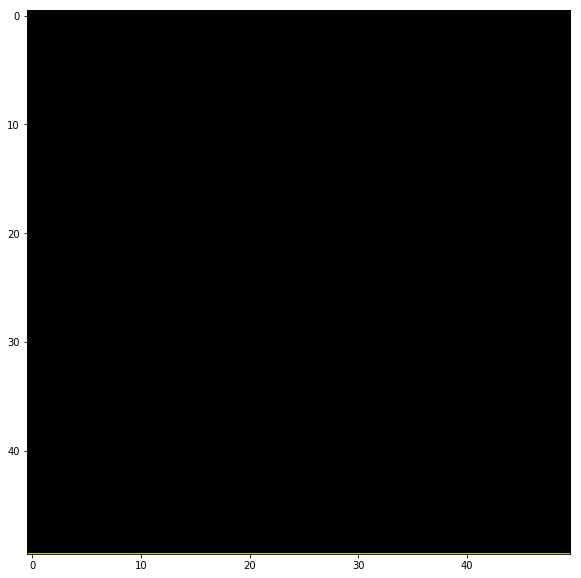

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


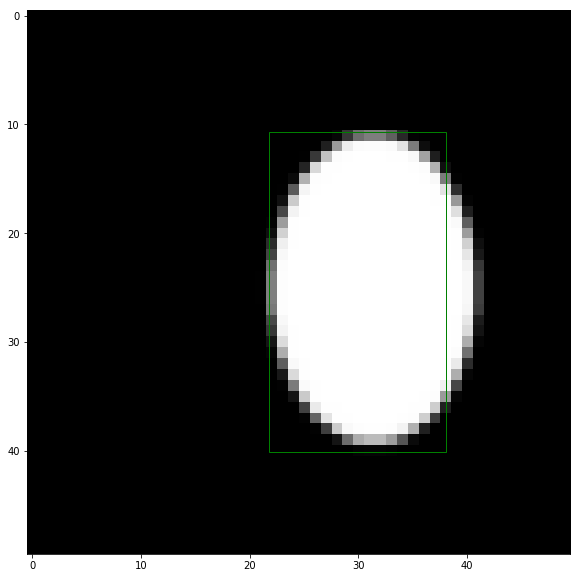

1 [44.52773  22.44794  32.511074 58.904636]
[[1, [22.54003870559386, 11.745209983929357, 18.601065023202924, 28.23038954347127]]]


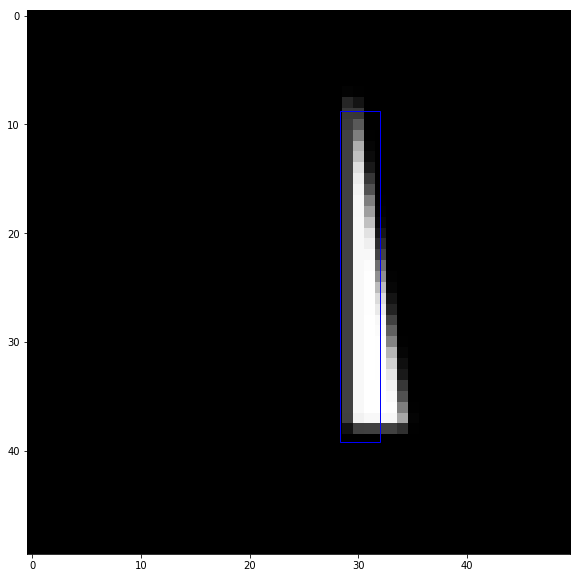

2 [57.56672  18.563982  7.367623 60.926186]
[[2, [29.862629021571856, 8.022387697249442, 4.784824043173214, 30.125704982111984]]]


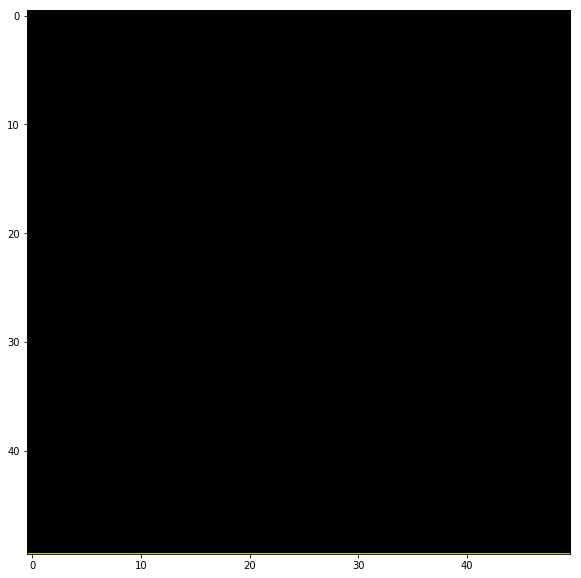

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


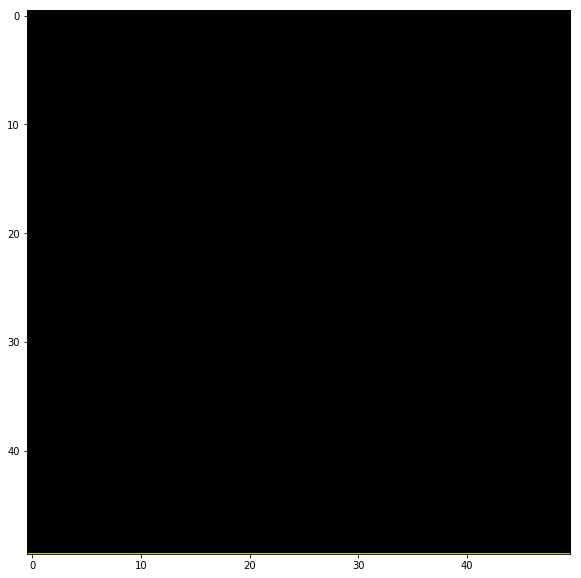

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


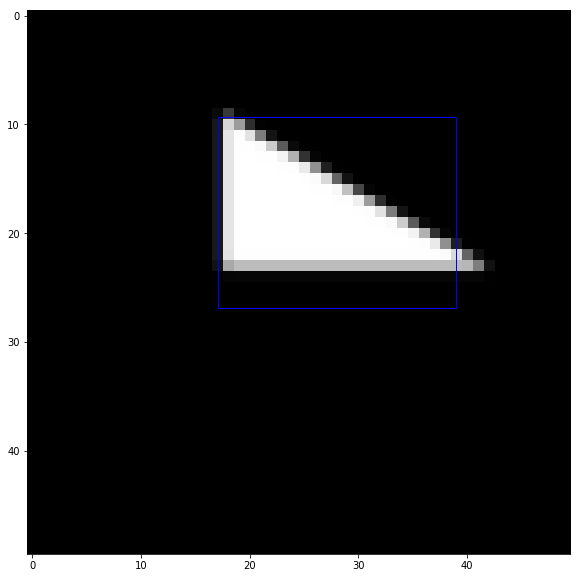

2 [35.078587 19.72797  43.788517 35.05726 ]
[[2, [18.16819975164386, 9.657138217382766, 24.003789309477362, 13.913745445789367]]]


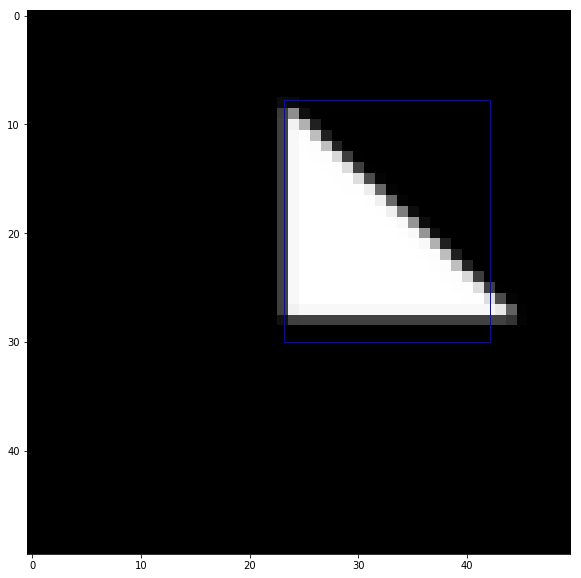

2 [47.32221 16.55103 37.91399 44.46494]
[[2, [23.763466173868323, 8.78362081840701, 21.110573989072023, 19.438805322847447]]]


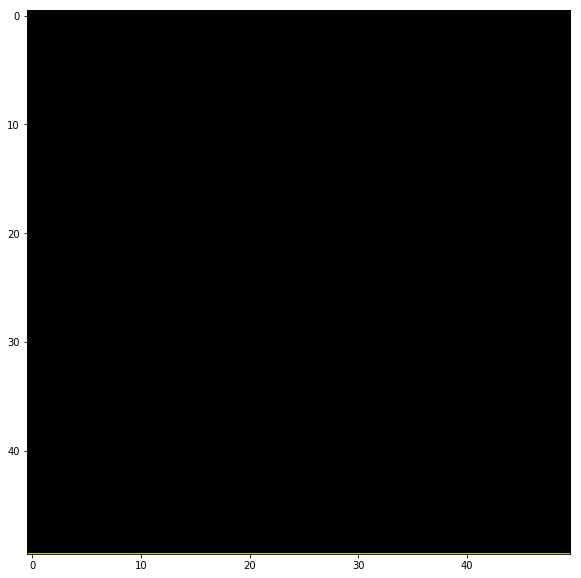

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


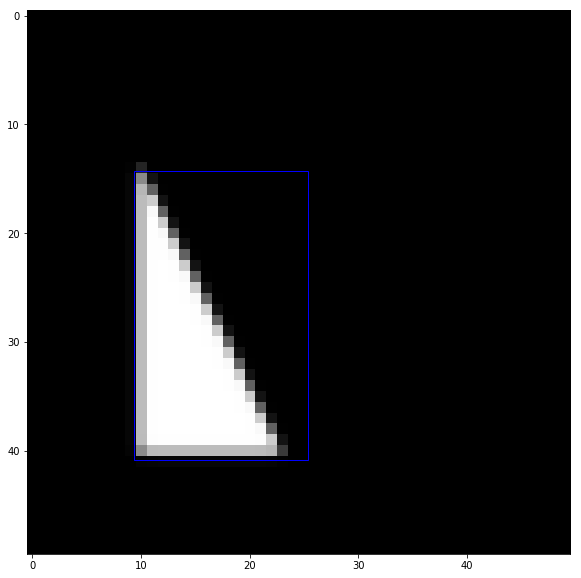

2 [19.748158 29.580093 31.937582 53.215343]
[[2, [10.314674115540862, 14.626546197235497, 13.099684801112538, 25.918910285555935]]]


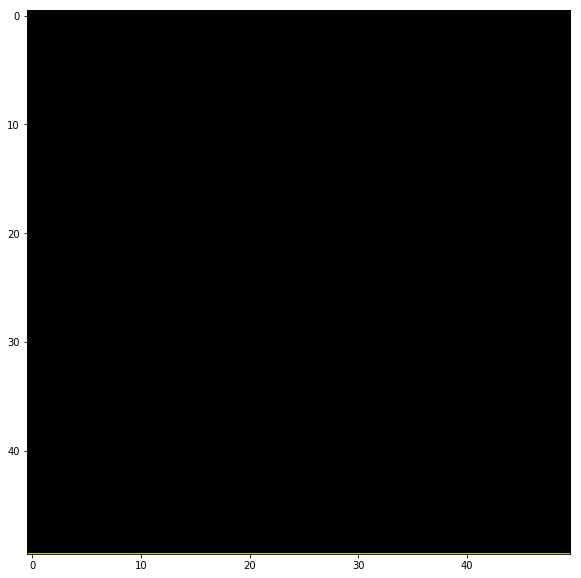

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


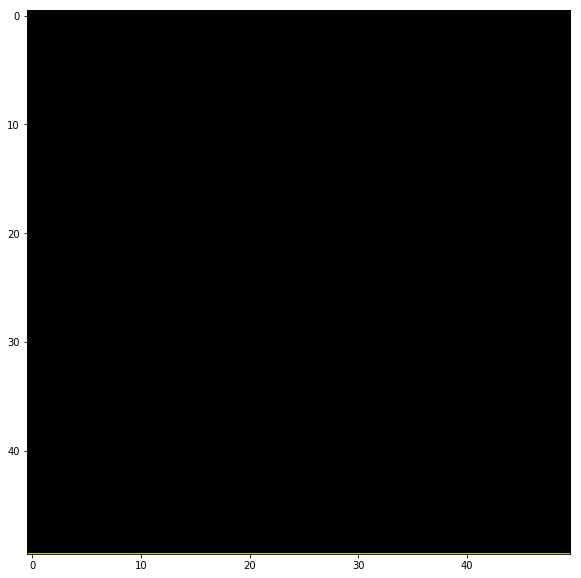

3 [ -0.22436976  -0.15468448 100.23522    100.009415  ]
[]


In [14]:
for i in range(20):    
    cat=np.argmax(cat_pred[i])
    label=[ [cat,bbox_pred[i]*50]]
    plot_example(np.squeeze(bb.X_develop[i]),label)
    print(cat,bbox_pred[i]*100)
    print(bb.Y_develop[i])


## Identifying more than one thing at a time

**Run the next several cells to get your model training before we get started**


That worked pretty well, but we have another problem - what if there is more than one object in the image? 
* There are several ways to handle this:
    * Scan the image (like we did with the cancer example)
        * This works but can be expensive
    * Use multiple detectors
        * Strategry used by algorithms like SSD (single shot detector) or YOLO (you only look once)
        * Faster and better suited for devices
* Will discuss using multiple detectors
    * The algorithm above had 1 detector, and predicted one bounding box and one class label
    * We can add more of them to detect several objects
* Challenges
    * How do we efficiently add detectors?
    * How do we assign objects to detectors?

* Convolutional Detectors
    * One way to add a lot of detectors quickly is to not use a dense layer at all
        * We replace the dense network above with two convolutional layers
        * Each layer will have 4 filters (so the output will have 4 channels)
            * We can apply a softmax to each pixel in one layer to get a category prediction
            * We can use the second layer for bounding box predictions
        
    

<img src=../assets/network_diagrams/multi_object_identifier.png>

In the case below our output CNN layers will have a shape of 5 pixels by 5 pixels,
so we we'll assign each of these pixels to watch a box in the original input image.
The area each pixel is watching for is called a prior box or an anchor. 

If the center of an object in in the box we assign it to that detector, otherwise a detector is assigned a background class.

<img src=../assets/network_diagrams/Detectors.png>

Another detail is instead of directly predicting the bounding box with make a prediction with respect to the prior box, we predict the x,y offsets to the new bounding box and the length and width scales.  

    
  


# Build It
Same problem now with the possiblity of multiple objects

In [15]:
bb_multi=BBToyData(multi_object= True)

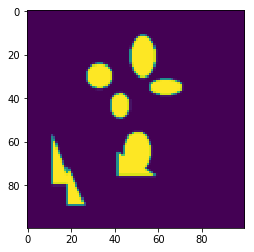

In [16]:

plt.imshow(np.squeeze(bb_multi.X_train[10]))

In [17]:

cnn_input=tf.keras.layers.Input( shape=bb_multi.X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(16, (4,4),strides=2,padding='same')(cnn_input) #50x50
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 
#cnn_activation=tf.keras.layers.BatchNormalization()(cnn_activation) 
#cnn_activation=tf.keras.layers.Dropout(0.5)(cnn_activation) 

cnn_layer2=tf.keras.layers.Convolution2D(32, (4,4),strides=2,padding='same')(cnn_activation) #25x25
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 
#cnn_activation=tf.keras.layers.Dropout(0.5)(cnn_activation) 

#cnn_activation=tf.keras.layers.BatchNormalization()(cnn_activation) 

cnn_layer3=tf.keras.layers.Convolution2D(64, (10,10),strides=5,padding='same')(cnn_activation) #5x5
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 
#cnn_activation=tf.keras.layers.BatchNormlization()(cnn_activation) 
#cnn_activation=tf.keras.layers.Dropout(0.5)(cnn_activation) 



###Prediction Layers
prediction=tf.keras.layers.Convolution2D(4,(5,5),padding='same',activation='softmax')(cnn_activation)
#Softmax is applied to the last 
bbox_offset=tf.keras.layers.Convolution2D(4,(5,5),padding='same')(cnn_activation)


model=tf.keras.models.Model(cnn_input,[prediction,bbox_offset])

model.compile(loss=['categorical_crossentropy','mse'],
                  optimizer='adam',
                  metrics=[])
model.summary()

test,test1=model.predict(bb_multi.X_train[0:1])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 16)   272         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 50, 50, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 25, 25, 32)   8224        leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [18]:


def get_labels(input_labels):
    Y_train=[[],[]]
    
    for image_labels in input_labels:
        class_features=np.zeros((5,5,4))
        class_features[:,:,3]=1. #Defaults to no class

        bbox_features=np.zeros((5,5,4))
        bbox_features[:,:,2:]=1. #Scale =1

        detected=[]
        
        
        for i,(cat,bbox) in enumerate(image_labels):
            bbox=[i/100. for i in bbox] # Normalize
            bbox_center_x=int((bbox[0]+bbox[2]/2.)//0.2) #priorbox bin
            bbox_center_y=int((bbox[1]+bbox[3]/2.)//0.2) #priorbox bin
            
            bbox_offset_x=(bbox[0]+bbox[2]/2.)/0.2-(bbox_center_x+0.5)#priorbox bin
            bbox_offset_y=(bbox[1]+bbox[3]/2.)/0.2-(bbox_center_y+0.5) #priorbox bin
            
            bbox_scale_x=bbox[2]/0.2
            bbox_scale_y=bbox[3]/0.2
            # Y comes first here
            class_features[bbox_center_y,bbox_center_x,cat]=1.
            class_features[bbox_center_y,bbox_center_x,3]=0

            bbox_features[bbox_center_y,bbox_center_x,:]=[bbox_offset_x,bbox_offset_y,bbox_scale_x,bbox_scale_y]
        Y_train[0].append(np.expand_dims(class_features,0))
        Y_train[1].append(np.expand_dims(bbox_features,0))
    Y_train[0]=np.concatenate(Y_train[0])
    Y_train[1]=np.concatenate(Y_train[1])
    
    return Y_train
Y_train=get_labels(bb_multi.Y_train)
Y_develop=get_labels(bb_multi.Y_develop)
Y_test=get_labels(bb_multi.Y_test)







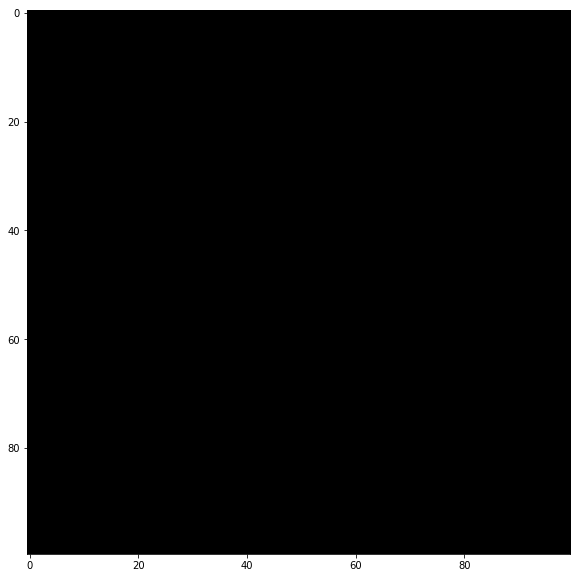

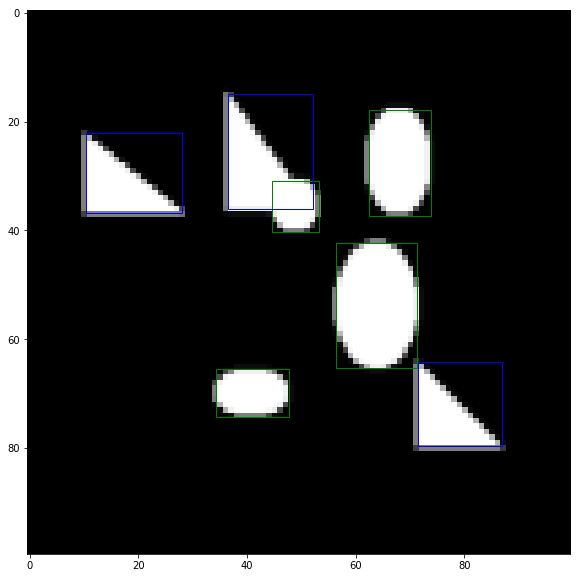

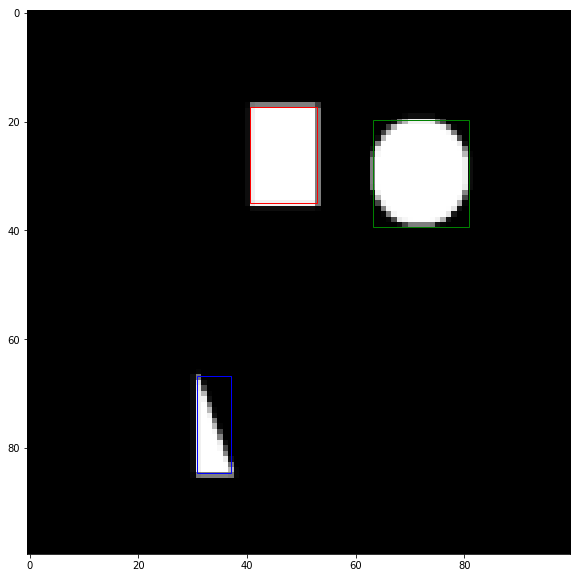

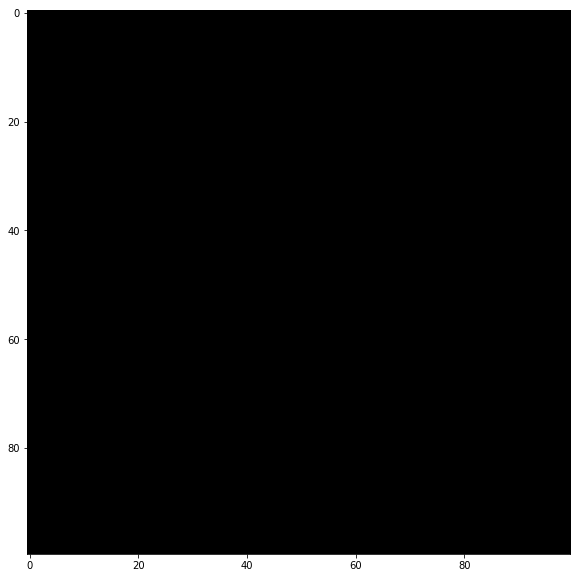

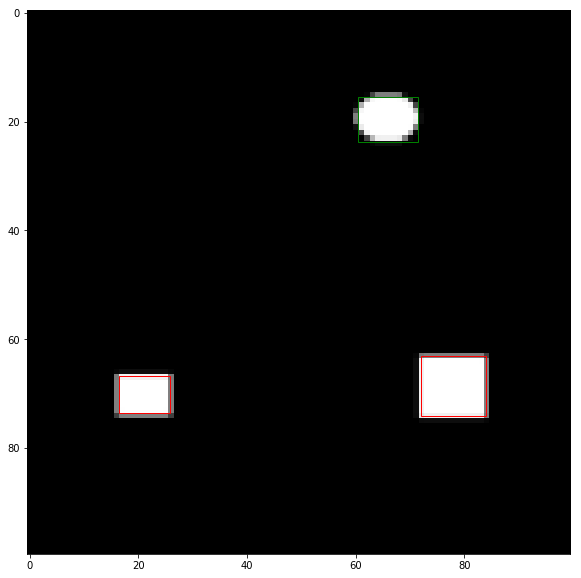

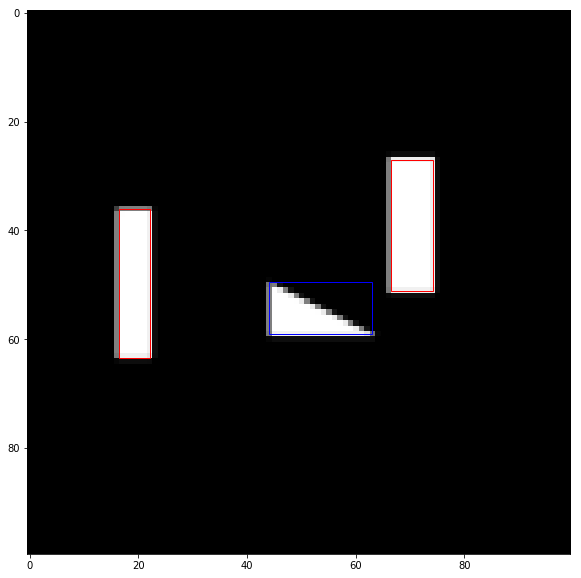

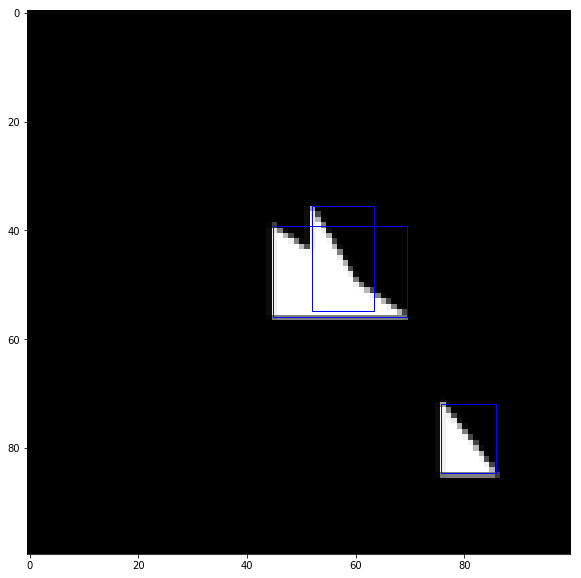

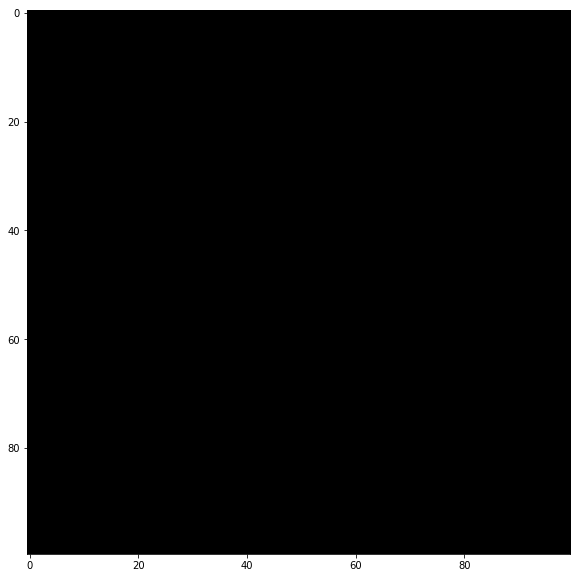

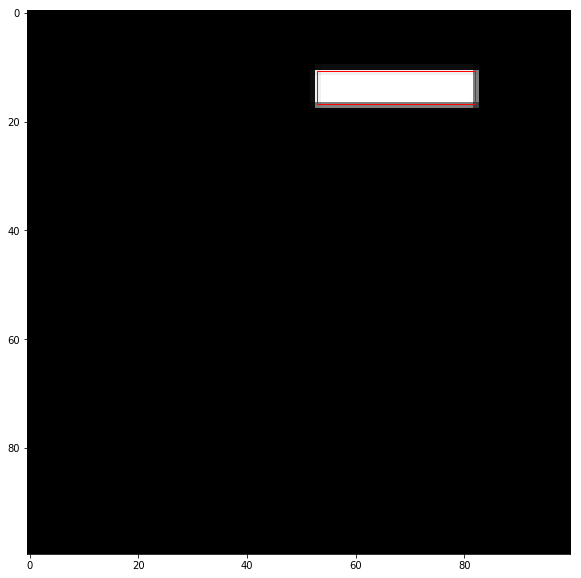

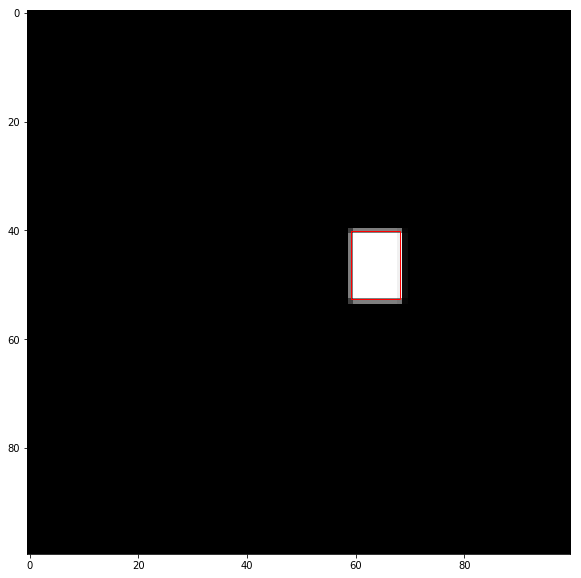

In [ ]:

#plt.imshow(np.argmax(Y_train[0][0],axis=-1))
bbox=Y_train[1][0]
plt.show()


for i in range(10):
    index=np.random.randint(len(bb_multi.X_train))
    plot_example(np.squeeze(bb_multi.X_train[index]),bb_multi.Y_train[index])

In [20]:
print(len(bb_multi.X_train))
history=model.fit(bb_multi.X_train, Y_train, 
        batch_size=32, epochs=15, verbose=1,
        validation_data=(bb_multi.X_develop,Y_develop)
                 )


15923
Train on 15923 samples, validate on 2080 samples
Epoch 1/15
15923/15923 [==============================] - 93s 6ms/step - loss: 9.0813 - conv2d_5_loss: 8.3118 - conv2d_6_loss: 0.7694 - val_loss: 6.2282 - val_conv2d_5_loss: 5.8563 - val_conv2d_6_loss: 0.3719
Epoch 2/15
15923/15923 [==============================] - 108s 7ms/step - loss: 5.2815 - conv2d_5_loss: 4.9738 - conv2d_6_loss: 0.3076 - val_loss: 4.6419 - val_conv2d_5_loss: 4.3721 - val_conv2d_6_loss: 0.2697
Epoch 3/15
15923/15923 [==============================] - 110s 7ms/step - loss: 4.1164 - conv2d_5_loss: 3.8497 - conv2d_6_loss: 0.2666 - val_loss: 3.7136 - val_conv2d_5_loss: 3.4636 - val_conv2d_6_loss: 0.2500
Epoch 4/15
15923/15923 [==============================] - 112s 7ms/step - loss: 3.4227 - conv2d_5_loss: 3.1820 - conv2d_6_loss: 0.2407 - val_loss: 3.4261 - val_conv2d_5_loss: 3.1899 - val_conv2d_6_loss: 0.2362
Epoch 5/15
15923/15923 [==============================] - 112s 7ms/step - loss: 3.0654 - conv2d_5_loss: 2.

([<matplotlib.lines.Line2D at 0x2aabc2af9e48>],
 [<matplotlib.lines.Line2D at 0x2aabc2b01320>])

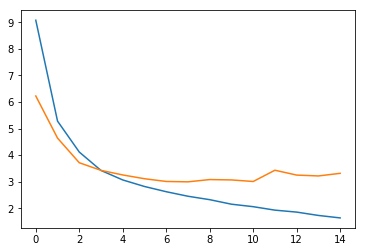

In [21]:
plt.plot(history.history['loss']),plt.plot(history.history['val_loss'])

In [ ]:

def predictions_to_labels(image,cat_map,bbox_map,show_background=False):
    # Each map is a 5x5 image 
    labels=[]
    for y,r in enumerate(bbox_map):
        for x,v in enumerate(r):
            cat=np.argmax(cat_map[y,x,:])
#            if cat_map[y,x,cat] < 0.9:continue
            if not show_background and cat==3:continue
            #Center - l/2
            width=.2*bbox_map[y,x,2]
            height=.2*bbox_map[y,x,3]
            if cat !=3:
                print(bbox_map[y,x,:])
                print(cat_map[y,x,:])

            x_start=(x+bbox_map[y,x,0]+.5)*.2 -width/2.
            y_start=(y+bbox_map[y,x,1]+.5)*.2 -height/2.
            labels.append([cat,[(x_start)*100,y_start*100,width*100,height*100]])
    return labels



cat_map,bbox_map=model.predict(bb_multi.X_develop)




[0.17791988 0.13624553 1.0686982  0.75769234]
[0.88008875 0.00339287 0.00873708 0.10778128]
[0.03070032 0.06483246 0.98331636 0.64438343]
[1.3227080e-03 1.0965975e-02 9.8756814e-01 1.4325655e-04]


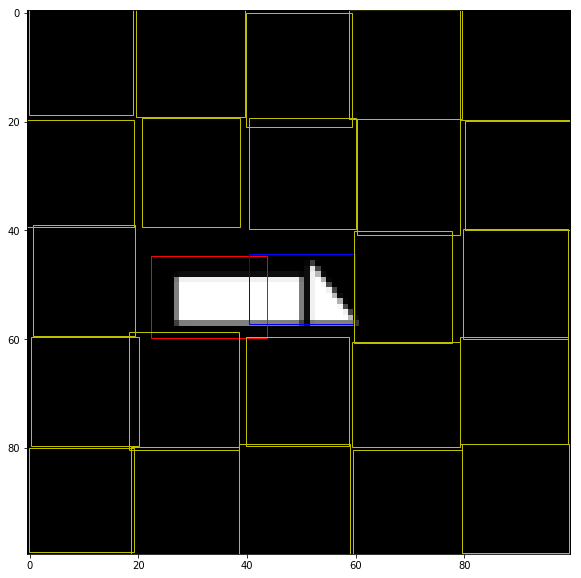

Predicted Labels


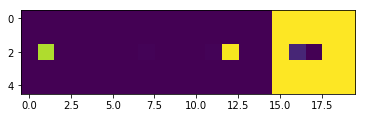

True Labels


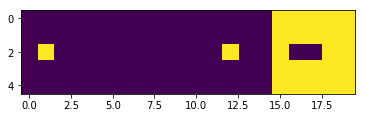

[0.2720672 0.1486684 0.6758028 1.0876714]
[9.7667778e-01 1.8651555e-03 2.1457095e-02 3.9029228e-08]


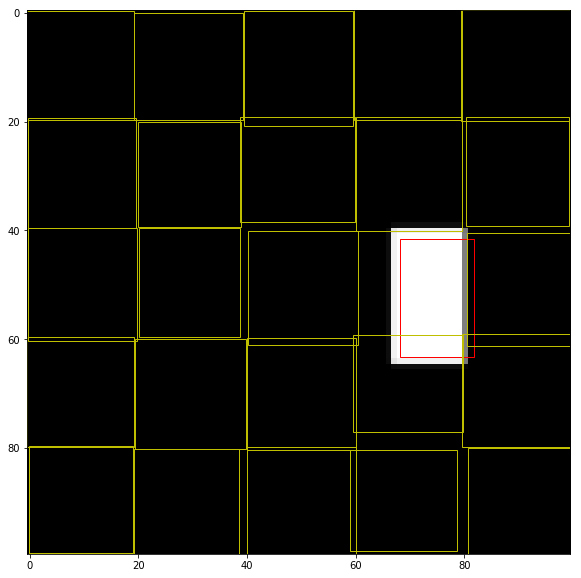

Predicted Labels


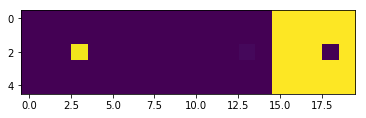

True Labels


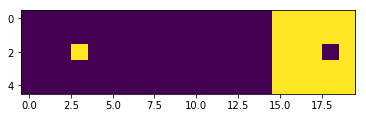

[-0.19108818  0.28446066  0.9664608   0.5405817 ]
[8.9593607e-01 9.4815545e-02 9.2200860e-03 2.8347515e-05]
[0.2346096  0.07469023 0.97316146 0.832719  ]
[9.2815763e-01 2.4919072e-04 1.3111164e-03 7.0281982e-02]
[-0.24908222  0.11791544  0.88111436  0.73346484]
[0.8461474  0.05852336 0.01180597 0.08352328]
[0.27350006 0.25008458 0.8994905  0.56021416]
[1.0057670e-01 5.5450178e-04 8.9691180e-01 1.9570158e-03]
[-0.27868783  0.00933138  0.81413114  0.7026171 ]
[9.4496304e-01 2.2232675e-03 5.2520078e-02 2.9361309e-04]
[0.23653352 0.04676488 0.8065299  0.6849577 ]
[0.81452554 0.06328543 0.02580593 0.09638309]
[ 0.13980514 -0.10860674  1.0147154   0.7873698 ]
[9.7187769e-01 5.9877131e-03 2.2134542e-02 7.5759327e-10]
[-0.15473627  0.28186807  0.652367    0.7282624 ]
[7.5451851e-01 2.3665561e-01 8.8258553e-03 2.5611637e-08]


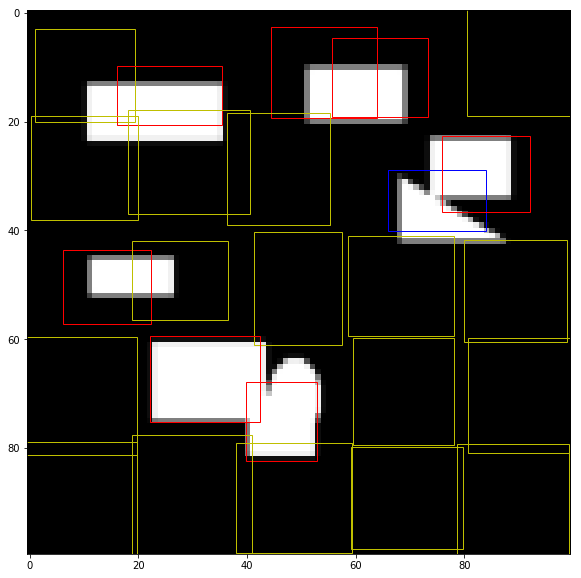

Predicted Labels


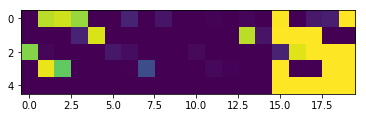

True Labels


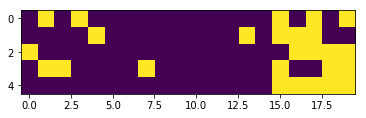

[-0.07307379  0.04955472  0.57386774  1.2340605 ]
[2.8530112e-03 1.1788497e-03 9.9596786e-01 2.1076343e-07]
[-0.04021997  0.1871536   1.0864874   0.568122  ]
[3.0453056e-01 3.0827793e-01 3.8719150e-01 3.3218338e-08]
[-0.09168626  0.19536953  1.0389247   0.6820368 ]
[1.7352100e-04 7.4466615e-04 9.1979390e-01 7.9287827e-02]


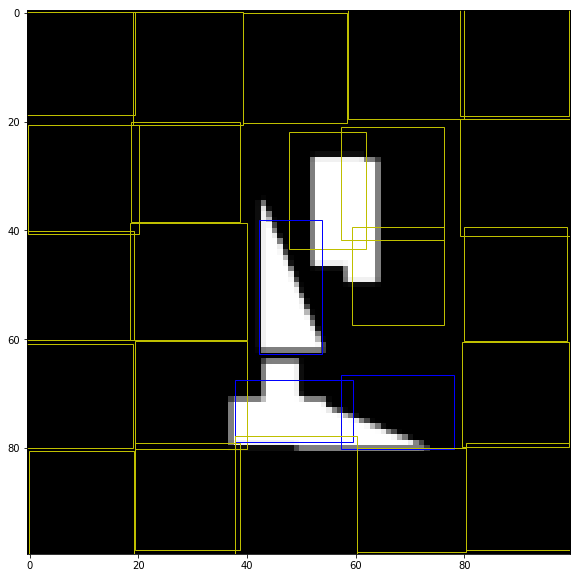

Predicted Labels


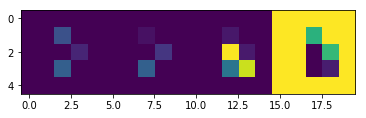

True Labels


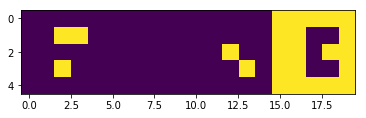

[ 0.0121702  -0.19557887  0.4897923   0.79901135]
[4.7760378e-03 9.8538917e-01 9.8346919e-03 1.0177691e-07]
[ 0.23949113 -0.073081    1.0141214   0.5333957 ]
[1.0423613e-02 9.6532428e-01 2.4252180e-02 5.3436309e-12]


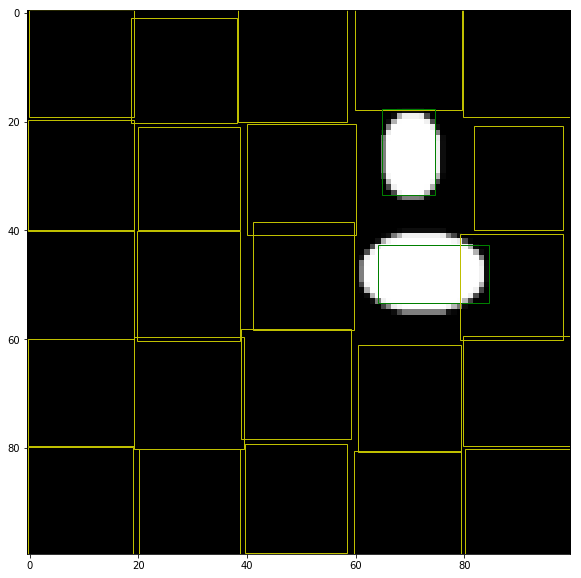

Predicted Labels


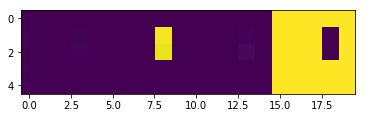

True Labels


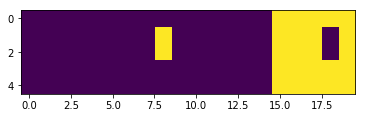

[-0.38818836 -0.28226486  0.70017606  0.74681103]
[2.6142993e-04 9.9805212e-01 1.6865025e-03 9.9890020e-11]
[0.23066531 0.22672206 0.57167065 0.96349335]
[5.3608958e-03 9.9439597e-01 9.0038593e-05 1.5316914e-04]
[0.02865265 0.17642578 0.74866194 0.7968531 ]
[0.38405263 0.07826809 0.21360117 0.32407808]
[ 0.1314839  -0.25935224  0.8405395   0.77389336]
[0.57306486 0.08487308 0.01253958 0.3295225 ]


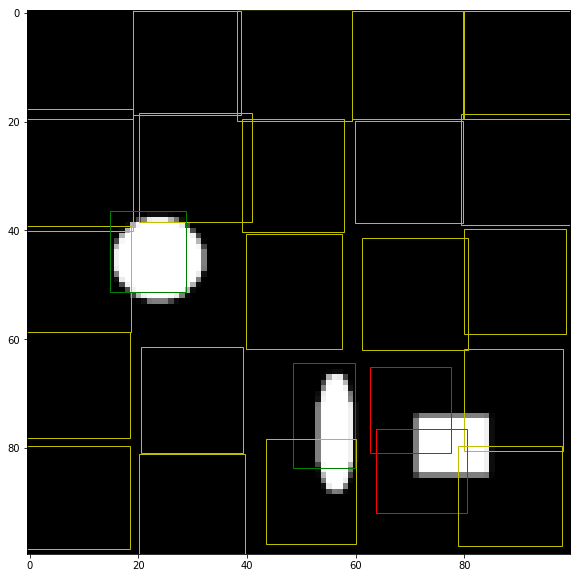

Predicted Labels


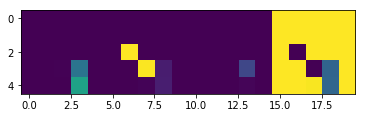

True Labels


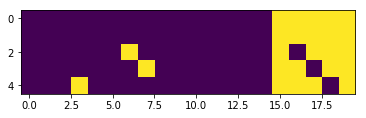

[-0.20707175  0.08779707  0.25029173  0.7243928 ]
[5.3969980e-03 9.9243987e-01 2.1630414e-03 1.1699224e-07]


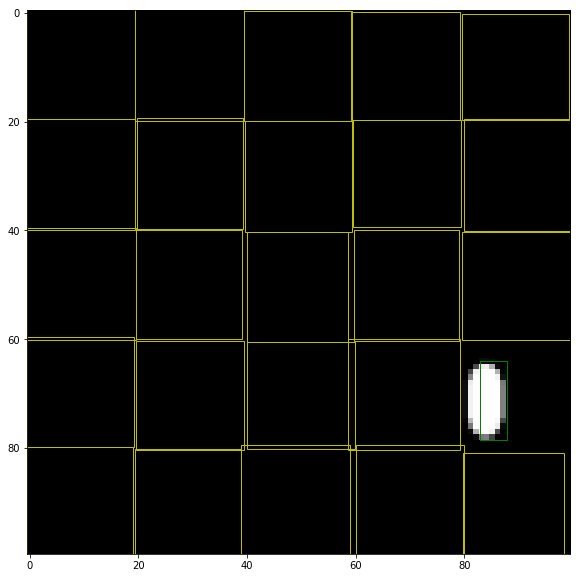

Predicted Labels


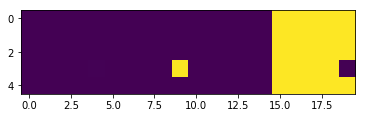

True Labels


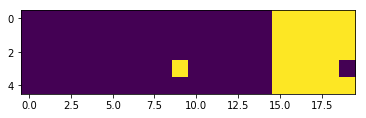

[0.16855891 0.1942404  0.6978129  0.7711534 ]
[0.00355926 0.00204005 0.9927977  0.00160308]


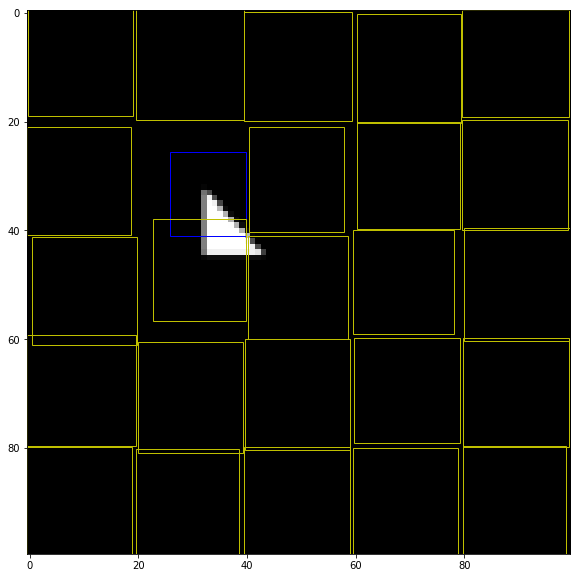

Predicted Labels


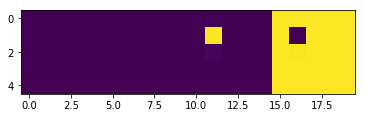

True Labels


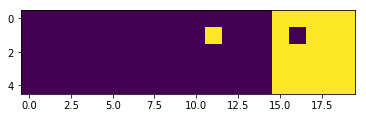

[ 0.31612247 -0.07114697  0.8492833   1.1575954 ]
[0.9300132  0.00212236 0.03643608 0.03142839]


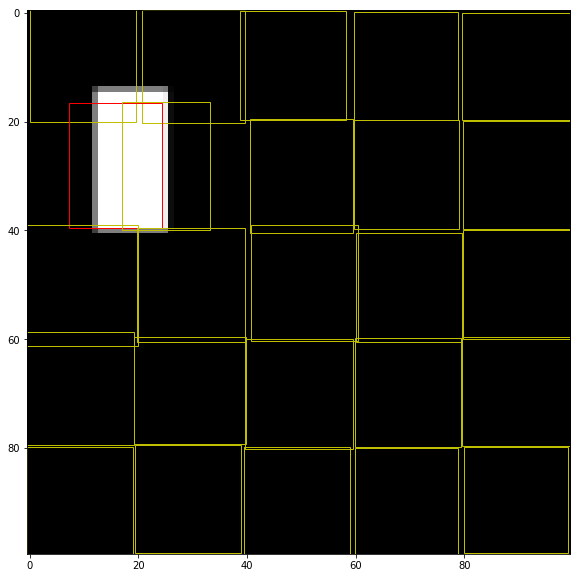

Predicted Labels


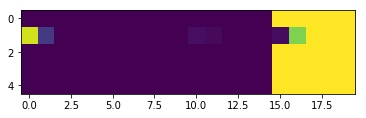

True Labels


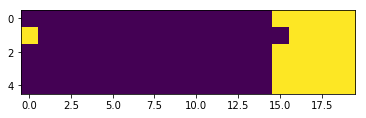

[-0.45311213 -0.15734151  0.6688892   0.8645724 ]
[1.1472042e-03 9.9014997e-01 8.7028714e-03 6.1921108e-09]
[ 0.09525494 -0.17782393  0.5393742   0.58954674]
[6.8583555e-04 3.8586752e-04 9.9695802e-01 1.9702706e-03]


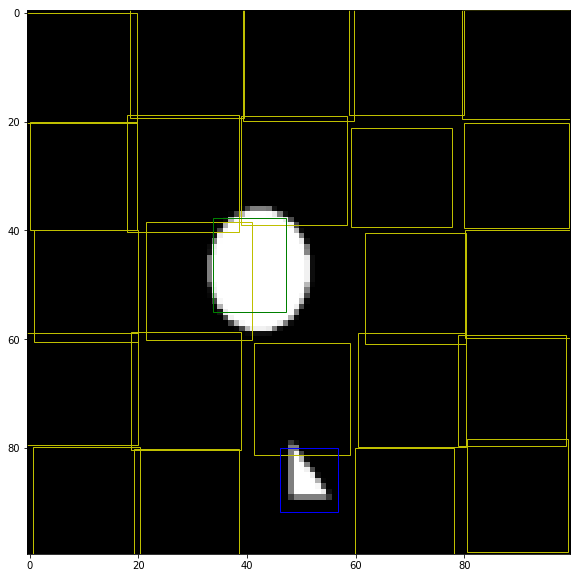

Predicted Labels


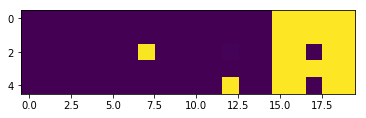

True Labels


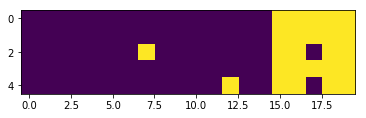

In [ ]:
for i in range(10):
    labels=predictions_to_labels(np.squeeze(bb_multi.X_develop[i]),cat_map[i],bbox_map[i],show_background=True)

#    labels=predictions_to_labels(np.squeeze(bb_multi.X_develop[i]),Y_develop[0][i],Y_develop[1][i],show_background=True)

    plot_example(np.squeeze(bb_multi.X_develop[i]),labels)

    print('Predicted Labels')
    plt.imshow(np.hstack([cat_map[i,:,:,n] for n in range(4)]))
    plt.show()

    print('True Labels')
    plt.imshow(np.hstack([Y_develop[0][i,:,:,n] for n in range(4)]))
    plt.show()



## A Fullly Functional Algorigthm

There are still problems with the simple model above
* What happens if more than one object matches a box?
* You might see problems if the objects are really big
* You might also see problems if the objects are really small

The best object detection algorithm use several prior boxes per location: i.e SSD

<img src="https://miro.medium.com/max/974/1*51joMGlhxvftTxGtA4lA7Q.png">

* We used one convolutional map that was 5x5
* These algorithms use several maps with different sizes (for smaller and larger objects)
* We only used square prior boxes
     * These algorithms use several aspect ratio bounding boxes per point
     
**These are well engineered, and can take some time to reproduce, so we'll use an existing implementation**


Using this model is a good example of how everything we've talked about can be rolled to a one analysis

# Don't be a hero part2

Use an existing package from github
https://github.com/pierluigiferrari/ssd_keras

* Fairly Normal Open Source Package
* Limited Docs
* Some Examples
* Not Super Easy to use
    * I'll try to point out where what you learned above will help you


In [24]:

os.chdir('./ssd_keras')


# Back to the Goal

We are trying to design a system to help with malaria diagnosis
   * We have blood smear slides labeled with bounding boxes
   * Each bounding box identifies an infected cell and its stage of development

In [25]:
cat_dict={}
cat_dict["background"]=0
cat_dict["ring"]=1
cat_dict['trophozoite']=2
cat_dict['schizont']=3
cat_dict['gametocyte']=4

int_2_cat={}
for i,v in cat_dict.items():
    int_2_cat[v]=i


## Ring stage example
<img src="https://www.mcdinternational.org/trainings/malaria/english/DPDx5/images/ParasiteImages/M-R/Malaria/falciparum/Pfal-rings-atlasdx.JPG">



# Our Annotations come in a json format
* These generally look like dictionaries to python users




In [26]:
#Data is stored on Talapas
images_dir="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/"
annotations_train="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/train.json"
annotations_develop="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/develop.json"
annotations_test="/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/test.json"

In [27]:
import json

train_label=json.load(open(annotations_train))


print(train_label.keys())
print("Image Data",train_label['images'][0])

print("Annotations 0",train_label['annotations'][0])
print("Annotations 1",train_label['annotations'][1])
print("Annotations 2",train_label['annotations'][2])
print("Annotations 3",train_label['annotations'][3])





dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
Image Data {'file_name': '/projects/bgmp/shared/2019_ML_workshop/datasets/BBBC041o/train/41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg', 'height': 1383, 'width': 1944, 'id': 0}
Annotations 0 {'segmentation': [[[245, 262, 180, 166]]], 'bbox': [245, 262, 180, 166], 'category_id': 2, 'image_id': 0, 'id': 0}
Annotations 1 {'segmentation': [[[209, 577, 168, 107]]], 'bbox': [209, 577, 168, 107], 'category_id': 3, 'image_id': 2, 'id': 2}
Annotations 2 {'segmentation': [[[463, 40, 109, 119]]], 'bbox': [463, 40, 109, 119], 'category_id': 1, 'image_id': 3, 'id': 3}
Annotations 3 {'segmentation': [[[1178, 779, 159, 146]]], 'bbox': [1178, 779, 159, 146], 'category_id': 1, 'image_id': 3, 'id': 4}


In the above, the list of annotations is matched to images using the tag image_id
* This is informational, but our package knows how to read these files

# Practice Working With Bounding Boxes
Use the lists above to answer the following questions:

# Question: How Many Annotations Are in the Train Set?


# What Box Has The Largest Area?

In [28]:
## Important data checks

all_bboxs=[ anno['bbox'] for anno in train_label['annotations']]
all_classes=[ anno['category_id'] for anno in train_label['annotations']]

for select in range(1,5):
    widths=[bb[2] for bb,cat in zip(all_bboxs,all_classes) if cat == select  ] 
    heights=[bb[3] for bb,cat in zip(all_bboxs,all_classes) if cat == select ] 
    areas=[bb[3]*bb[2] for bb,cat in zip(all_bboxs,all_classes) if cat == select  ] 

    print( len(widths), int_2_cat[select], " in training set" )
    print("Average Width", np.mean(widths),'pixels')
    print("Average Height", np.mean(heights),'pixels')

    print("Max Width", np.max(widths),'pixels')
    print("Max Height", np.max(heights),'pixels')

    print("Min Width", np.min(widths),'pixels')
    print("Min Height", np.min(heights),'pixels')

    print("__________________")


420 ring  in training set
Average Width 131.07380952380953 pixels
Average Height 127.75714285714285 pixels
Max Width 239 pixels
Max Height 240 pixels
Min Width 76 pixels
Min Height 82 pixels
__________________
1421 trophozoite  in training set
Average Width 135.34764250527797 pixels
Average Height 135.16959887403237 pixels
Max Width 296 pixels
Max Height 255 pixels
Min Width 58 pixels
Min Height 63 pixels
__________________
176 schizont  in training set
Average Width 141.3125 pixels
Average Height 143.39204545454547 pixels
Max Width 211 pixels
Max Height 217 pixels
Min Width 82 pixels
Min Height 81 pixels
__________________
135 gametocyte  in training set
Average Width 132.94074074074075 pixels
Average Height 132.22222222222223 pixels
Max Width 209 pixels
Max Height 194 pixels
Min Width 81 pixels
Min Height 84 pixels
__________________


* Our targets are mostly trophozites 
* Our targets are fairly square 
* Our targets are ~70-255 pixels in size 

# Building Our Model - Part 1 Data
Lots of imports for our package

In [29]:
import h5py
import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast
from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation



#from models.keras_ssd7 import build_model
from models.keras_ssd300 import ssd_300 as build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

import matplotlib.patches as patches




Using TensorFlow backend.


## Remember how we needed to properly preprocess the data for existing packages?
This one has custom data generators for that

In [30]:
img_height = 1200 # Height of the input images
img_width = 1600 # Width of the input images
img_channels = 3 # Number of color channels of the input images

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
image_augmentation=SSDDataAugmentation(img_height,img_width)



train_dataset.parse_json(        images_dirs=images_dir,
                                 annotations_filenames=[annotations_train],
                                 ground_truth_available=True,
                                 include_classes='all'
                                 )



develop_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)



develop_dataset.parse_json(       images_dirs=images_dir,
                                 annotations_filenames=[annotations_develop],
                                 ground_truth_available=True,
                                 include_classes='all'
                                 )


test_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

test_dataset.parse_json(         images_dirs=images_dir,
                                 annotations_filenames=[annotations_test],
                                 ground_truth_available=True,
                                 include_classes='all'
                                 )



Loading images into memory: 100%|██████████| 63/63 [00:04<00:00, 14.20it/s]


In [ ]:

plot_generator =    train_dataset.generate(batch_size=10,
                                         shuffle=False,
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)



Plot and draw example data

In [ ]:
#Grab a batch of images

batch_images, batch_labels, batch_filenames = next(plot_generator)
print(len(batch_images))
#These labels are in corner representation (xmin,ymin) (xmax,ymax)
# Need to convert to (xmin,ymin),(lenth,width)

def convert_ssd_labels(label):
    if len(label)==5:
        return [int(label[0]),[label[1],label[2],label[3]-label[1],label[4]-label[2]]] 
    if len(label)==6: #This are labels that also include a prediction
        return [int(label[0]),[label[2],label[3],label[4]-label[2],label[5]-label[3]]] 

for i in range(10):
    
    labels=[convert_ssd_labels(l) for l in batch_labels[i]]
    print(labels)
    plot_example(batch_images[i],labels)


# Build the Model - Part 2 The Model
* Step one: Panic!
* Step two: stay calm and follow the default configurations (I pulled these from a notebook example)

* Important things you need to know (from above)
    * Your CNN layers make as many predictions as there output maps
    * Your training annotations needed to be properly encoded
    * You eventually need to decode the training labels
* This is the same thing you did before, but now with more layers

**The Really Important Part**: All these settings, scales, aspect, ratios, etc., Must match. The setting for the Model must be the same as the encoder and the decoder
    




In [ ]:




n_classes=4

scales = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.

model = build_model(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color)


predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]


ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)


In [ ]:




batch_size=5
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[image_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

develop_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)



In [ ]:
model.summary()
_1,_2=next(train_generator)

print(_2.shape)



```
conv4_3_norm_mbox_conf (Conv2D) (None, 150, 200, 20) 92180       conv4_3_norm[0][0]               
__________________________________________________________________________________________________
fc7_mbox_conf (Conv2D)          (None, 75, 100, 30)  276510      fc7[0][0]                        
__________________________________________________________________________________________________
conv6_2_mbox_conf (Conv2D)      (None, 38, 50, 30)   138270      conv6_2[0][0]                    
__________________________________________________________________________________________________
conv7_2_mbox_conf (Conv2D)      (None, 19, 25, 30)   69150       conv7_2[0][0]                    
__________________________________________________________________________________________________
conv8_2_mbox_conf (Conv2D)      (None, 17, 23, 20)   46100       conv8_2[0][0]                    
__________________________________________________________________________________________________
conv9_2_mbox_conf (Conv2D)      (None, 15, 21, 20)   46100       conv9_2[0][0]                    
_________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1200, 1600, 3) 0                            
```

## Detectors at different resolution
### Boxes layer size

4 boxes per pixel * 4 predictions per box = 16 measurements
### Boxes layer size

5 (4+1 background) classes per box = 4*5=20

| Map Size      |Pixels in original image per prediction feature pixel|
| ------------- |-------------|
|150x200 |  8x8   |
|75x100  |  16x16 |
|38x50   |  ~32x32 |
|19x25   |  ~64x64 |
|17x23   |  ~64x64 |
|15x21   |  ~64x64 |


**One thing to notice immedialte is that our 'biggest' detector starts out at 64x64 pixels**
* What was the average size of our objects?

In [ ]:
model.load_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd300.h5")

if False:

    final_epoch     = 500
    
    history = model.fit_generator(generator=train_generator,
                              epochs=final_epoch,
                              steps_per_epoch=len(train_dataset.images)//batch_size,
                              validation_data=develop_generator,
                              validation_steps=len(develop_dataset.images)//batch_size,
                              )

    #model.save_weights("/projects/bgmp/shared/2019_ML_workshop/models/ssd300.h5")


In [ ]:
example_generator = develop_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'processed_labels'},
                                     keep_images_without_gt=False)




In [ ]:

batch_images,batch_labels=next(example_generator)
y_pred = model.predict(batch_images)
y_pred_decoded = decode_detections(y_pred,
                                       confidence_thresh=0.3,
                                       iou_threshold=0.1,
                                       top_k=200,
                                       normalize_coords=True,#normalize_coords,
                                       img_height=img_height,
                                       img_width=img_width)

for i in range(batch_size):
    labels=[convert_ssd_labels(l) for l in y_pred_decoded[i]]
    plot_example(batch_images[i],labels)



## Lets evaluate the model and do some experiments

We are far from perfect, but let's evaluate the model


## Testing Our Model

How good is it? An important part of these algorithms is evaluating the quality of matches. 

## Intersect Over Union
Intersect over union
<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png>

This is a very useful quanity

* 1 if the agreement is perfect, 0 if the boxes don't overlap
* Some entries may have several overlapping boxes
    * IOU can be a measure of how similar they are
        * If IOU > 0.1 only use the highest confidence bounding box
        (iou_threshold)
* Does a Truth Box have a match
    * Need to define how good a match counts as a match
        * If IOU > .5 a box matches the truth









In [ ]:

develop_for_pred_gen = develop_dataset.generate(batch_size=1,
                                     shuffle=False,
                                     transformations=[],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              },
                                     keep_images_without_gt=False)


true_labels=develop_dataset.labels
y_pred=model.predict_generator(develop_for_pred_gen,len(develop_dataset.images))


print("Done with Prediction")

In [ ]:
print("Decode First Five Images")
y_pred_decoded = decode_detections(y_pred[0:5],
                                   confidence_thresh=0.0, ##Not cofidence cut
                                   iou_threshold=0.1, # Overlap removal
                                   top_k=200, #Only the best 200 boxes
                                   normalize_coords=True,#normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

# Lets Look at One Image

In [ ]:
image_index=2

plt.imshow(develop_images[image_index])
plt.show()

print("labels",y_pred_decoded[image_index])
print("Truth", develop_dataset.labels[image_index])





# Decoded Labels for prediction are a list 
each element is in the form [best category, confidence, x,y,length,width]
sorted with best result last


In [ ]:

all_categories=[l[0] for l in y_pred_decoded[image_index] ]
all_confidences=[l[1] for l in y_pred_decoded[image_index]]

plt.hist(all_categories)
plt.xlabel("Classes")
plt.show()

plt.hist(all_confidences)
plt.show("All Confidences")


In [ ]:
# Not very confident, put lets look at the best two boxes
plot_labels=[convert_ssd_labels(l) for l in y_pred_decoded[image_index][-10:]]

print("Best 10 Boxes")
plot_example(develop_images[image_index],plot_labels)


print("Truth Boxes")
plot_labels=[convert_ssd_labels(l) for l in true_labels[image_index]]

plot_example(develop_images[image_index],plot_labels)
             
            


# Not Bad, Lets make a more Statistical Statment

Lets start by deciding anything with a confidence greater than 0.4 is a match (I encourage you to play with this)

In [ ]:

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.4, ##Add a Confidence Cut
                                   iou_threshold=0.1, 
                                   top_k=200, 
                                   normalize_coords=True,
                                   img_height=img_height,
                                   img_width=img_width)

# Lets Look at a Bunch of Distributions



In [ ]:
##
def area_minmax(bbox):
    xmin,ymin,xmax,ymax=bbox
    return(xmax-xmin)*(ymax-ymin)

def intersect_minmax(bbox1,bbox2):
    xmin1,ymin1,xmax1,ymax1=bbox1
    xmin2,ymin2,xmax2,ymax2=bbox2

    xintmin=max(xmin1,xmin2)
    yintmin=max(ymin1,ymin2)

    xintmax=min(xmax1,xmax2)
    yintmax=min(ymax1,ymax2)
   
    int_width=(xintmax-xintmin)    
    int_height=(yintmax-yintmin)
    if int_width <0 or int_height <0 :return 0
    return int_width*int_height
            
def iou(bbox1,bbox2):
    intarea=intersect_minmax(bbox1,bbox2)
    u=area_minmax(bbox1)+area_minmax(bbox2)-intarea
    return intarea/u




def flatten_labels(labels):
    values=[]
    for l in labels:
        for n in l:
            values.append(n)
    return values


t_all=flatten_labels(true_labels)
p_all=flatten_labels(y_pred_decoded)

true_area=[area_minmax(l[1:5]) for l in t_all]
pred_area=[area_minmax(l[2:6]) for l in p_all]

true_width=[l[3]-l[1] for l in t_all]
pred_width=[l[4]-l[2] for l in p_all]

true_x=[l[1] for l in t_all]
pred_x=[l[2] for l in p_all]

true_y=[l[2] for l in t_all]
pred_y=[l[3] for l in p_all]


true_cat=[l[0] for l in t_all]
pred_cat=[l[0] for l in p_all]



plt.hist(true_area,range=(50*50,200*200),bins=10,label='true',histtype='step')
plt.hist(pred_area,range=(50*50,200*200),bins=10,label='pred',histtype='step')
plt.xlabel("Area")
plt.legend()
plt.show()

plt.hist(true_width,range=(50,200),bins=10,label='true',histtype='step')
plt.hist(pred_width,range=(50,200),bins=10,label='pred',histtype='step')
plt.xlabel("Width")

plt.legend()
plt.show()

plt.hist(true_cat,range=(0,10),bins=10,label='true',histtype='step')
plt.hist(pred_cat,range=(0,10),bins=10,label='pred',histtype='step')
plt.xlabel("Category")
plt.legend()
plt.show()


plt.hist(true_x,range=(0,1600),bins=10,label='true',histtype='step')
plt.hist(pred_x,range=(0,1600),bins=10,label='pred',histtype='step')
plt.xlabel("X")
plt.legend()
plt.show()


plt.hist(true_x,range=(0,1200),bins=10,label='true',histtype='step')
plt.hist(pred_x,range=(0,1200),bins=10,label='pred',histtype='step')
plt.xlabel("Y")
plt.legend()
plt.show()





# What do you see?

# How well do the results match the truth

Make another choice if a has an IOU > 0.1 it has a match (I also encourage you to play with this, remember we're creating algorithms and the often means making choices to be more or less conservative )

In [ ]:

#match best box
def match(truth,pred):
    best=[]
    for t in truth:
        matches=[ [iou(t[1:],p[2:]),i] for i,p in enumerate(pred)]
        matches.sort()
        if matches!=[]:            
            best.append(matches[-1]) # largest iou
        else:
            best.append([0,-1])
    return best

matches=[match(t,p) for t,p in zip(true_labels,y_pred_decoded)]

n_no_matches=0
n_matches=0
correct=0
for index,image in enumerate(matches):
    for li,m in enumerate(image):
        if m[0] < .1 or m[1]==-1:n_no_matches+=1 # no match
        else:
            n_matches+=1 # no match
            y_pred_decoded[index][m[1]][0]==true_labels[index][li][0]
            correct+=1

print(n_matches/(n_no_matches+n_matches)*100,"% True Boxes Matched")
print(correct/(n_no_matches+n_matches)*100,"% True Boxes Matched and identified")
print(len(p_all)-n_matches," wrong boxes", correct,"correct boxes" )


# That was a Lot of Code, Some Take Aways:

## Multi-Box Detectors can be used to find objects in images
* You can write them yourself, but a lot of prexisting packages are around
* The magic that makes this work is using fully convolutional predictors (no dense layers at the end)
   * This also means you can use any size image
* You have to encode annotations, and decode them
    * How exactly this is done will depend on the exact algorithm
    * There are a lot of ways to mess this up, so don't get discouraged if it dosen't work at first
* One of the first things you can tune with these models is to pick better anchor box sizes and aspect ratios!
    
# Other ways to do this
   * Yolo (you only look once)
   * Recursive CNNS (similar to scaning an image like we did last lecture)
    
# If you finish early, I encourage you to play around with this or the previous datasets for practice, and we will wrap up at the end
    
    


